<a href="https://colab.research.google.com/github/conwayjw97/ImageColourizationModels/blob/master/src/DeterministicConvNetCifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Variables

In [0]:
IMAGE_COUNT = 50000
TRAINING_IMAGE = 0
TEST_IMAGE = 0
BATCH_SIZE = 1000
CLASSIFICATION_EPOCHS = 30
COLOURISATION_EPOCHS = 100
LOAD_CLASSIFICATION_MODEL = False
LOAD_COLOURISATION_MODEL = False

# Import Statements

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#%load_ext tensorboard

import tensorflow as tf
import datetime, os
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.ndimage.filters import gaussian_filter1d
from tensorflow.keras import datasets, layers, models, backend, utils, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)
base_dir = "/content/gdrive/My Drive/DeterministicConvNetCifar10/"

TensorFlow 2.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Load Dataset

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

170500096/170498071 [==============================] - 2s 0us/step


# Convert Classification Images to Grayscale

In [0]:
train_gray_images = tf.image.rgb_to_grayscale(train_images[:IMAGE_COUNT])
test_gray_images = tf.image.rgb_to_grayscale(test_images[:IMAGE_COUNT])

# Create the Classification CNN



In [5]:
# 3-block vgg style architecture
# https://arxiv.org/abs/1409.1556
def create_classification_model():
  model = models.Sequential()
  # Feature detection layers
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(train_gray_images.shape[1], train_gray_images.shape[2], train_gray_images.shape[3])))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  # Classifier layers
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dense(10, activation='softmax'))
  opt = optimizers.SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

create_classification_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         7

# Train the Classification Model

In [25]:
def train_image_loader(x_images, y_labels, batch_size):
  datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=45, width_shift_range=0.1, brightness_range=(0.8, 1.0), zoom_range=[0.5, 1.5])
  datagen.fit(x_images)
  # Keras needs the generator to loop infinitely
  while True:
    for x_batch, y_batch in datagen.flow(x_images, y_labels, batch_size=batch_size):
      print("\nx_batch.shape: ", x_batch.shape, " - y_batch.shape: ", y_batch.shape)
      yield (x_batch, y_batch)  

def test_image_loader(x_images, y_labels, batch_size):
  datagen = ImageDataGenerator()
  # Keras needs the generator to loop infinitely
  while True:
    for x_batch, y_batch in datagen.flow(x_images, y_labels, batch_size=batch_size):
      yield (x_batch, y_batch) 

model = create_classification_model()
checkpoint_dir = os.path.dirname(base_dir + "classification.ckpt")

if(LOAD_CLASSIFICATION_MODEL):
  model.load_weights(checkpoint_dir)
  total_loss, total_accuracy = model.evaluate(test_gray_images, utils.to_categorical(test_labels), verbose=2)
  total_loss = np.array(total_loss)
  total_accuracy = np.array(total_accuracy)
else:
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  train_iterator = datagen.flow(train_gray_images, utils.to_categorical(train_labels), batch_size=BATCH_SIZE)
  history = model.fit_generator(train_iterator, steps_per_epoch=int(train_images.shape[0]/BATCH_SIZE), epochs=CLASSIFICATION_EPOCHS, validation_data=(test_gray_images, utils.to_categorical(test_labels)), validation_steps=int(test_gray_images.shape[0]/BATCH_SIZE))
  model.save_weights(checkpoint_dir)
  total_loss = history.history["loss"]
  total_val_loss = history.history["val_loss"]
  total_accuracy = history.history["accuracy"]
  total_val_accuracy = history.history["val_accuracy"]

Epoch 1/30
50/50 [==============================] - 11s 230ms/step - loss: 2.3116 - accuracy: 0.1400 - val_loss: 2.2418 - val_accuracy: 0.1932
Epoch 2/30
50/50 [==============================] - 9s 177ms/step - loss: 2.2036 - accuracy: 0.2113 - val_loss: 2.1508 - val_accuracy: 0.2365
Epoch 3/30
50/50 [==============================] - 9s 177ms/step - loss: 2.1306 - accuracy: 0.2353 - val_loss: 2.0786 - val_accuracy: 0.2614
Epoch 4/30
50/50 [==============================] - 9s 176ms/step - loss: 2.0735 - accuracy: 0.2567 - val_loss: 2.0126 - val_accuracy: 0.2956
Epoch 5/30
50/50 [==============================] - 9s 183ms/step - loss: 2.0160 - accuracy: 0.2807 - val_loss: 1.9504 - val_accuracy: 0.3141
Epoch 6/30
50/50 [==============================] - 9s 178ms/step - loss: 1.9719 - accuracy: 0.3038 - val_loss: 1.9102 - val_accuracy: 0.3275
Epoch 7/30
50/50 [==============================] - 9s 177ms/step - loss: 1.9313 - accuracy: 0.3180 - val_loss: 1.8594 - val_accuracy: 0.3533
Epoch

# Classification Diagnostic Learning Curves

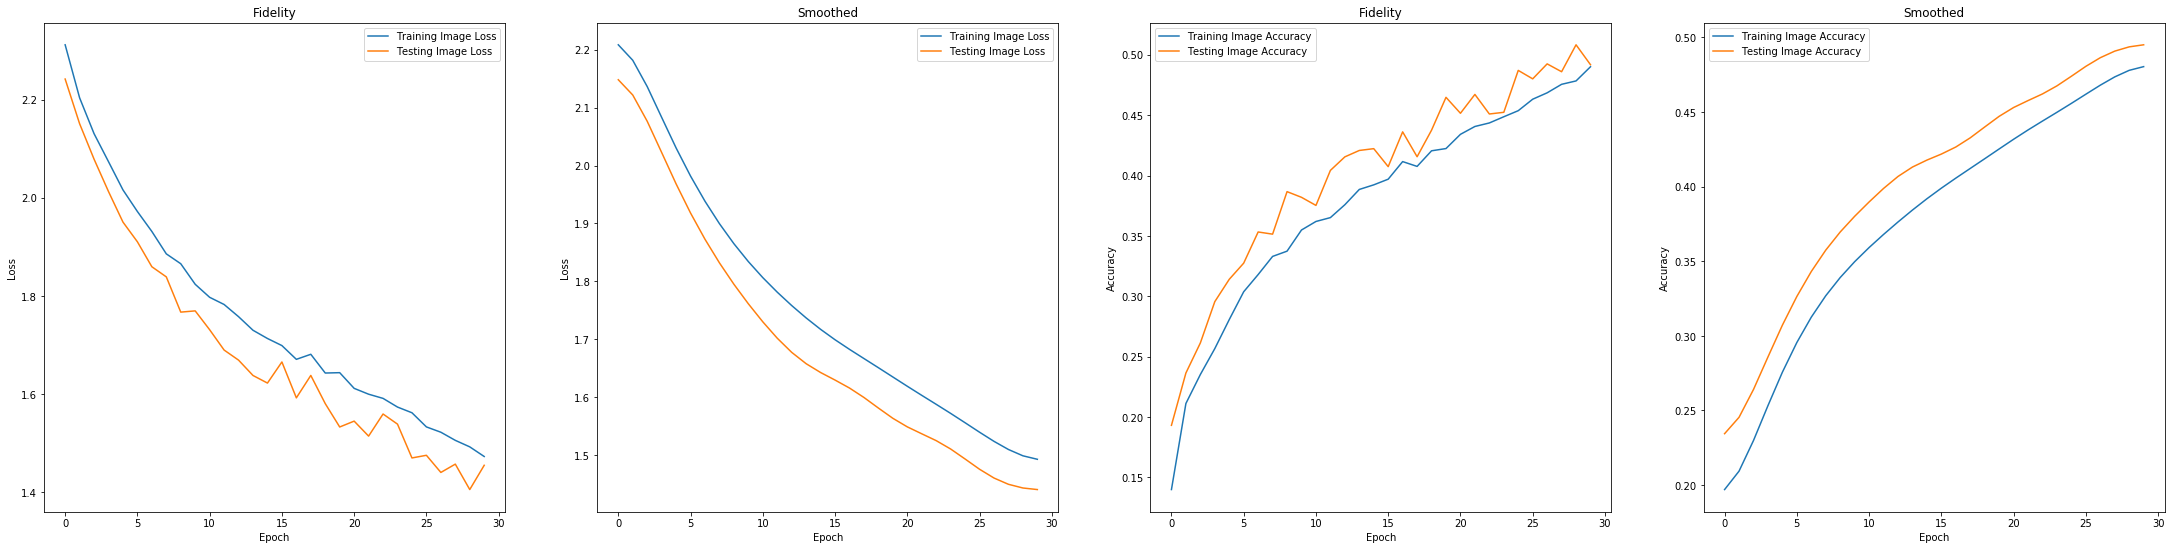

In [26]:
fig = plt.figure(figsize=(38, 9))

fig.add_subplot(1,4,1)
plt.title("Fidelity")
plt.plot(total_loss, label="Training Image Loss")
if not (LOAD_CLASSIFICATION_MODEL):
  plt.plot(total_val_loss, label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

fig.add_subplot(1,4,2)
plt.title("Smoothed")
plt.plot(gaussian_filter1d(total_loss, sigma=2), label="Training Image Loss")
if not (LOAD_CLASSIFICATION_MODEL):
  plt.plot(gaussian_filter1d(total_val_loss, sigma=2), label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

fig.add_subplot(1,4,3)
plt.title("Fidelity")
plt.plot(total_accuracy, label="Training Image Accuracy")
if not (LOAD_CLASSIFICATION_MODEL):
  plt.plot(total_val_accuracy, label="Testing Image Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

fig.add_subplot(1,4,4)
plt.title("Smoothed")
plt.plot(gaussian_filter1d(total_accuracy, sigma=2), label="Training Image Accuracy")
if not (LOAD_CLASSIFICATION_MODEL):
  plt.plot(gaussian_filter1d(total_val_accuracy, sigma=2), label="Testing Image Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Classification Results

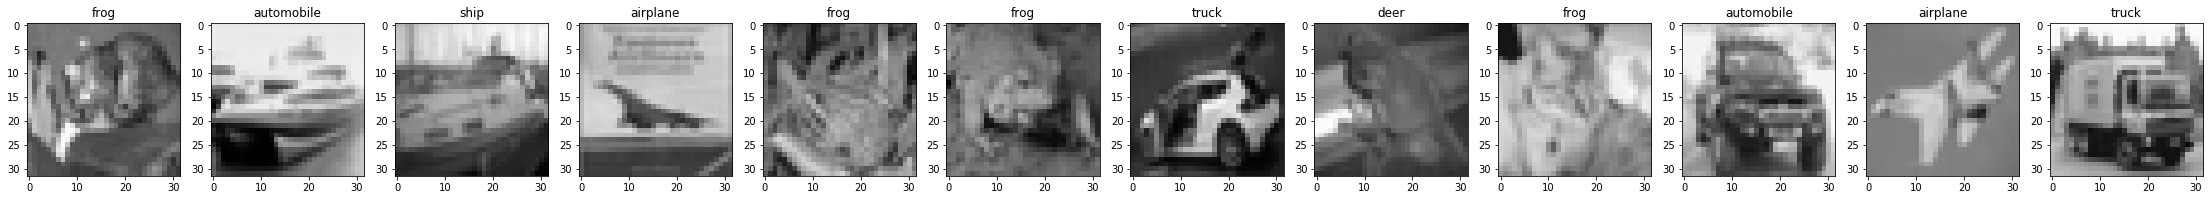

In [28]:
image_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

output_count = 12

fig = plt.figure(figsize=(39,39))
for i in range(output_count):
  result = model.predict_classes(tf.expand_dims(test_gray_images[i], 0))
  fig.add_subplot(1,output_count,i+1)
  plt.title(image_labels[int(result)])
  plt.imshow(tf.image.grayscale_to_rgb(test_gray_images[i]))

# Convert Colourisation Images to YUV

In [0]:
# Outputs a tensor of the same shape as the images tensor, containing the YUV 
# value of the pixels. The output is only well defined if the value in images 
# are in [0,1].
#https://zhengtq.github.io/2018/12/27/tensorflow-disturb-yuv/

train_yuvImages = tf.image.rgb_to_yuv(train_images[:IMAGE_COUNT])
train_y = tf.expand_dims(train_yuvImages[:,:,:,0], 3)
train_uv = train_yuvImages[:,:,:,1:]

test_yuvImages = tf.image.rgb_to_yuv(test_images[:IMAGE_COUNT])
test_y = tf.expand_dims(test_yuvImages[:,:,:,0], 3)
test_uv = test_yuvImages[:,:,:,1:]

# Create the Colourisation CNN

In [32]:
# Conv2D(filters (number of output filters)
#           - determine parameter number
#        kernel_size (size of convolution window)
#        activation (activation function to use)
#        padding ("valid" or "same")
#        strides (strides of the convolution along the height and width)
#           - strides greater than 1 will downsample
#        input_shape (only used on the first layer of the model))
#
# UpSampling2D(size (upsampling factors for rows and columns))

#https://github.com/emilwallner/Coloring-greyscale-images

# For an odd-sized filter, all the previous layer pixels would be symmetrically 
# around the output pixel. If you think of convolution as an interpolation from 
# the given pixels to a center pixel, we cannot interpolate to a center pixel 
# using an even-sized filter.

def create_colourisation_model():
  model = models.Sequential()
  model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  return model

create_colourisation_model().summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 30, 30, 64)        640       
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 15, 15, 64)        36928     
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 15, 15, 128)       73856     
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 8, 8, 128)         147584    
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 4, 4, 256)         590080    
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 4, 4, 128)       


# Train the Colourisation Model

In [36]:
# fit(x (input data)
#     y (target data)
#     batch_size (samples per gradient update)
#        - smaller batch size = more stochastic
#     epochs (epochs to train the model))

#https://stackoverflow.com/questions/47200146/keras-load-images-batch-wise-for-large-dataset

def train_image_loader(x_train, y_train, batch_size):
  datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=45, width_shift_range=0.1, brightness_range=(0.8, 1.0), zoom_range=[0.5, 1.5])
  datagen.fit(x_train)
  # Keras needs the generator to loop infinitely
  while True:
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=batch_size):
      print("\ncount: ", count, " - x_batch.shape: ", x_batch.shape, " - y_batch.shape: ", y_batch.shape)
      yield (x_batch, y_batch)  

def test_image_loader(x_test, y_test, batch_size):
  datagen = ImageDataGenerator()
  # Keras needs the generator to loop infinitely
  while True:
    for x_batch, y_batch in datagen.flow(x_test, y_test, batch_size=batch_size):
      yield (x_batch, y_batch)  

model = create_colourisation_model()
model.compile(optimizer='rmsprop', loss='mse')
checkpoint_dir = os.path.dirname(base_dir + "colourisation.ckpt")
runtime_epochs = int(COLOURISATION_EPOCHS/4)
total_loss = total_val_loss = total_accuracy = total_val_accuracy = []
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_iterator = datagen.flow(train_y, train_uv, batch_size=BATCH_SIZE)

if not (LOAD_COLOURISATION_MODEL):
  history = model.fit_generator(train_iterator, steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_y, test_uv), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE))
  # history = model.fit_generator(train_image_loader(train_y, train_uv, BATCH_SIZE), steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_image_loader(test_y, test_uv, BATCH_SIZE)), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE))
  model.save_weights(checkpoint_dir)
  total_loss += history.history["loss"]
  total_val_loss += history.history["val_loss"]

Epoch 1/25
50/50 [==============================] - 10s 200ms/step - loss: 0.0179 - val_loss: 0.0036
Epoch 2/25
50/50 [==============================] - 10s 194ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 3/25
50/50 [==============================] - 10s 197ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 4/25
50/50 [==============================] - 10s 196ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 5/25
50/50 [==============================] - 10s 194ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 6/25
50/50 [==============================] - 10s 194ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 7/25
50/50 [==============================] - 10s 194ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 8/25
50/50 [==============================] - 10s 194ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 9/25
50/50 [==============================] - 10s 194ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 10/25
50/50 [==============================] - 10s 192ms/step - loss: 0.0034 - val_lo

KeyError: ignored

In [37]:
if not (LOAD_COLOURISATION_MODEL):
  history = model.fit_generator(train_iterator, steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_y, test_uv), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE))
  # history = model.fit_generator(train_image_loader(train_y, train_uv, BATCH_SIZE), steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_image_loader(test_y, test_uv, BATCH_SIZE)), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE))
  total_loss += history.history["loss"]
  total_val_loss += history.history["val_loss"]

Epoch 1/25
50/50 [==============================] - 10s 199ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 2/25
50/50 [==============================] - 10s 192ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 3/25
50/50 [==============================] - 10s 192ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 4/25
50/50 [==============================] - 10s 195ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/25
50/50 [==============================] - 10s 190ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 6/25
50/50 [==============================] - 10s 192ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 7/25
50/50 [==============================] - 10s 194ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 8/25
50/50 [==============================] - 10s 196ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 9/25
50/50 [==============================] - 10s 191ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 10/25
50/50 [==============================] - 10s 195ms/step - loss: 0.0030 - val_lo

In [38]:
if not (LOAD_COLOURISATION_MODEL):
  history = model.fit_generator(train_iterator, steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_y, test_uv), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE))
  # history = model.fit_generator(train_image_loader(train_y, train_uv, BATCH_SIZE), steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_image_loader(test_y, test_uv, BATCH_SIZE)), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE))
  total_loss += history.history["loss"]
  total_val_loss += history.history["val_loss"]

Epoch 1/25
50/50 [==============================] - 10s 196ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 2/25
50/50 [==============================] - 9s 189ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 3/25
50/50 [==============================] - 10s 202ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 4/25
50/50 [==============================] - 10s 194ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 5/25
50/50 [==============================] - 10s 196ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 6/25
50/50 [==============================] - 10s 193ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 7/25
50/50 [==============================] - 10s 198ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 8/25
50/50 [==============================] - 10s 198ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 9/25
50/50 [==============================] - 10s 195ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 10/25
50/50 [==============================] - 10s 193ms/step - loss: 0.0028 - val_los

In [39]:
if not (LOAD_COLOURISATION_MODEL):
  history = model.fit_generator(train_iterator, steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_y, test_uv), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE))
  # history = model.fit_generator(train_image_loader(train_y, train_uv, BATCH_SIZE), steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_image_loader(test_y, test_uv, BATCH_SIZE)), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE))
  total_loss += history.history["loss"]
  total_val_loss += history.history["val_loss"]

Epoch 1/25
50/50 [==============================] - 10s 199ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 2/25
50/50 [==============================] - 10s 191ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 3/25
50/50 [==============================] - 10s 191ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 4/25
50/50 [==============================] - 10s 195ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 5/25
50/50 [==============================] - 9s 190ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 6/25
50/50 [==============================] - 10s 191ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 7/25
50/50 [==============================] - 10s 192ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 8/25
50/50 [==============================] - 10s 195ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 9/25
50/50 [==============================] - 9s 189ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 10/25
50/50 [==============================] - 10s 199ms/step - loss: 0.0026 - val_loss

In [0]:
if(LOAD_COLOURISATION_MODEL):
  model.load_weights(checkpoint_dir)
  total_loss, total_accuracy = model.evaluate(test_gray_images, utils.to_categorical(test_labels), verbose=2)
  total_loss = np.array(total_loss)
  total_accuracy = np.array(total_accuracy)

# Colourisation Diagnostic Learning Curves

In [41]:
fig = plt.figure(figsize=(18, 9))

fig.add_subplot(1,2,1)
plt.title("Fidelity")
plt.plot(total_loss[1:], label="Training Image Loss")
if(!LOAD_COLOURISATION_MODEL):
  plt.plot(total_val_loss[1:], label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

fig.add_subplot(1,2,2)
plt.title("Smoothed")
plt.plot(gaussian_filter1d(total_loss[1:], sigma=2), label="Training Image Loss")
if(!LOAD_COLOURISATION_MODEL):
  plt.plot(gaussian_filter1d(total_val_loss[1:], sigma=2), label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

fig = plt.figure(figsize=(18, 9))

fig.add_subplot(1,2,1)
plt.title("Fidelity")
plt.plot(total_accuracy[1:], label="Training Image Accuracy")
if(!LOAD_COLOURISATION_MODEL):
  plt.plot(total_val_accuracy[1:], label="Testing Image Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

fig.add_subplot(1,2,2)
plt.title("Smoothed Training and Testing Loss over Epochs")
plt.plot(gaussian_filter1d(total_accuracy[1:], sigma=2), label="Training Image Accuracy")
if(!LOAD_COLOURISATION_MODEL):
  plt.plot(gaussian_filter1d(total_val_accuracy[1:], sigma=2), label="Testing Image Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

SyntaxError: ignored

# Training Results

In [0]:
print(model.evaluate(train_y, train_uv, batch_size=BATCH_SIZE))
output = model.predict(train_y)
result = np.zeros((IMAGE_COUNT, 32, 32, 3))
result[:,:,:,0] = train_y[:,:,:,0]
result[:,:,:,1:] = output

output_count = 12

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Input")
  plt.imshow(tf.image.grayscale_to_rgb(train_y[TRAINING_IMAGE+i]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(train_images[TRAINING_IMAGE+i])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[TRAINING_IMAGE+i]))
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[TRAINING_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[TRAINING_IMAGE+i,:,:,2])

# Testing Results

In [0]:
print(model.evaluate(test_y, test_uv, batch_size=BATCH_SIZE))
output = model.predict(test_y)
result = np.zeros((test_yuvImages.shape[0], 32, 32, 3))
result[:,:,:,0] = test_y[:,:,:,0]
result[:,:,:,1:] = output
  
output_count = 12

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Input")
  plt.imshow(tf.image.grayscale_to_rgb(test_y[TEST_IMAGE+i]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(test_images[TEST_IMAGE+i])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[TEST_IMAGE+i]))
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(test_yuvImages[TEST_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[TEST_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(test_yuvImages[TEST_IMAGE+i,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[TEST_IMAGE+i,:,:,2])

# Layers activation visualization

In [0]:
#https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md
layer_outputs = [layer.output for layer in model.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(test_y) # Returns a list of five Numpy arrays: one array per layer activation

layer_names = []
for layer in model.layers[:12]:
  layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

images_per_row = 9

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
  n_features = layer_activation.shape[-1] # Number of features in the feature map
  size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
  n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  for col in range(n_cols): # Tiles each filter into a big horizontal grid
    for row in range(images_per_row):
      channel_image = layer_activation[0,:, :,col * images_per_row + row]
      channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')